# Disciple - 取引シミュレーション（Jupyter用）

In [14]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [15]:
res = AppRes()

excel = "ticks_20260115.xlsx"
code = "7011"
# code = "72#03"
# code = "83#06"
dict_setting = load_setting(res, code)
#dict_setting["PERIOD_MA_1"] = 30
#dict_setting["PERIOD_MA_2"] = 300
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/15
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 170
PERIOD_MA_2 : 500
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 10.0
THRESHOLD_DDR_MIN : 0.25


In [16]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-15 09:42:53.318396091  7011  売建  4682   100     NaN      
1      2 2026-01-15 09:43:30.377485037  7011  買埋  4675   100   700.0      
2      3 2026-01-15 10:15:59.395540953  7011  買建  4702   100     NaN      
3      4 2026-01-15 10:24:17.975588083  7011  売埋  4710   100   800.0      
4      5 2026-01-15 10:37:51.077203989  7011  買建  4724   100     NaN      
5      6 2026-01-15 10:44:16.436556101  7011  売埋  4732   100   800.0      
6      7 2026-01-15 10:46:51.792891026  7011  売建  4724   100     NaN      
7      8 2026-01-15 10:50:11.177681923  7011  買埋  4729   100  -500.0      
8      9 2026-01-15 11:08:53.890610933  7011  買建  4733   100     NaN      
9     10 2026-01-15 11:19:17.961873055  7011  売埋  4741   100   800.0      
10    11 2026-01-15 11:22:06.461112976  7011  売建  4734   100     NaN      
11    12 2026-01-15 11:27:13.466159105  7011  買埋  4740   100  -600.0      
12    13 2026-01-15 

In [17]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [18]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame({
    "注文日時": [date + pd.Timedelta(hours=9)],
    "累積損益": [0.0],
})

end_row = pd.DataFrame({
    "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
    "累積損益": [pl.iloc[-1]],
})

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row],
    ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-15 09:00:00.000000000       0.0
2026-01-15 09:42:53.318396091       0.0
2026-01-15 09:43:30.377485037     700.0
2026-01-15 10:15:59.395540953     700.0
2026-01-15 10:24:17.975588083    1500.0
2026-01-15 10:37:51.077203989    1500.0
2026-01-15 10:44:16.436556101    2300.0
2026-01-15 10:46:51.792891026    2300.0
2026-01-15 10:50:11.177681923    1800.0
2026-01-15 11:08:53.890610933    1800.0
2026-01-15 11:19:17.961873055    2600.0
2026-01-15 11:22:06.461112976    2600.0
2026-01-15 11:27:13.466159105    2000.0
2026-01-15 11:27:14.456562042    2000.0
2026-01-15 11:29:32.835261106    2900.0
2026-01-15 12:31:50.883138895    2900.0
2026-01-15 12:40:25.417464018    2200.0
2026-01-15 12:40:26.424098015    2200.0
2026-01-15 12:47:25.664824963    1900.0
2026-01-15 12:50:54.179260015    1900.0
2026-01-15 12:52:28.425065041    3100.0
2026-01-15 13:06:53.820409060    3100.0
2026-01-15 13:11:33.518543959    2500.0
2026-01-15 13:22:33.455456972    2500.0
2026-01-15 13:29:01.556819916    30

output/2026/01/15/7011_trend_profit.png


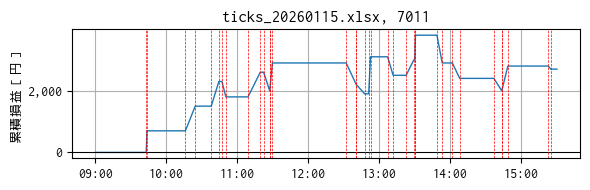

In [19]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [20]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1       ma2    slope1  rr  \
2026-01-15 09:00:03  1.768435e+09   4678  4678.000000  4678.000  0.000000   0   
2026-01-15 09:00:04  1.768435e+09   4678  4678.000000  4678.000  0.000000   0   
2026-01-15 09:00:05  1.768435e+09   4687  4681.000000  4681.000  1.800000   9   
2026-01-15 09:00:06  1.768435e+09   4687  4682.500000  4682.500  1.714286   9   
2026-01-15 09:00:07  1.768435e+09   4690  4684.000000  4684.000  1.650000  12   
...                           ...    ...          ...       ...       ...  ..   
2026-01-15 15:24:45  1.768458e+09   4797  4796.288235  4791.190  0.039216   3   
2026-01-15 15:24:46  1.768458e+09   4797  4796.317647  4791.206  0.035490   3   
2026-01-15 15:24:47  1.768458e+09   4798  4796.352941  4791.224  0.034314   3   
2026-01-15 15:24:48  1.768458e+09   4798  4796.388235  4791.240  0.033922   3   
2026-01-15 15:24:49  1.768458e+09   4797  4796.417647  4791.254  0.032549   3   

                   

In [21]:
df_tech["slope1"].describe()

count    19429.000000
mean         0.036895
std          0.043826
min          0.000000
25%          0.012353
50%          0.027255
75%          0.049804
max          1.800000
Name: slope1, dtype: float64

output/2026/01/15/7011_trend_technical.png


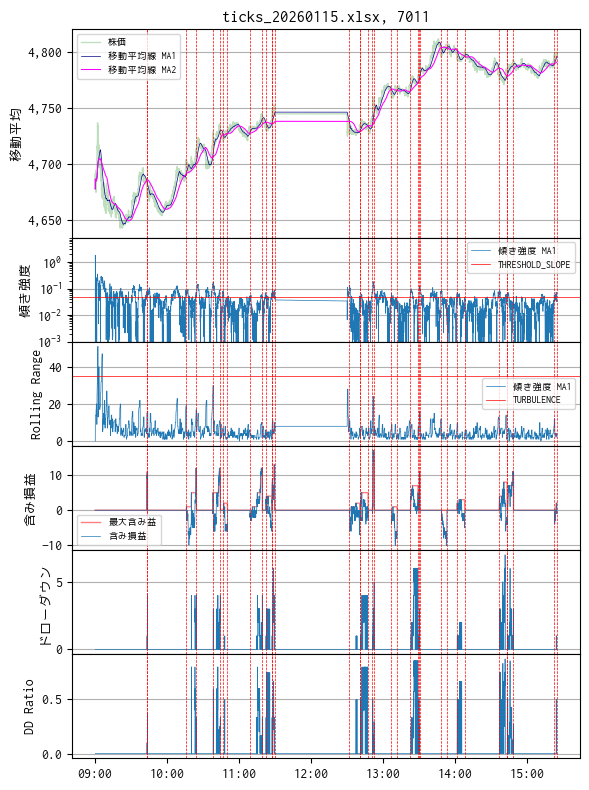

In [22]:
fig = plt.figure(figsize=(6, 8))
n = 6
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[1].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[1].set_yscale("log")
ax[1].set_ylabel("傾き強度")
ax[1].legend(fontsize=7)
_, y_high = ax[1].get_ylim()
ax[1].set_ylim(0.001, y_high)

ax[2].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[2].set_ylabel("Rolling Range")
ax[2].legend(fontsize=7)

ax[3].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[3].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[3].set_ylabel("含み損益")
ax[3].legend(fontsize=7)

ax[4].plot(df_tech["drawdown"], linewidth=0.5)
ax[4].set_ylabel("ドローダウン")

ax[5].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[5].set_ylabel("DD Ratio")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/15/7011_hist_slope.png


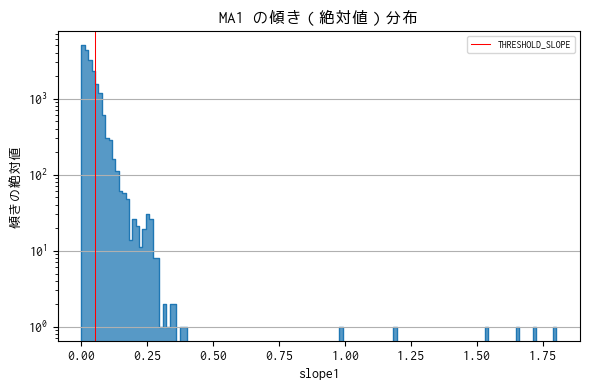

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/15/7011_hist_rr.png


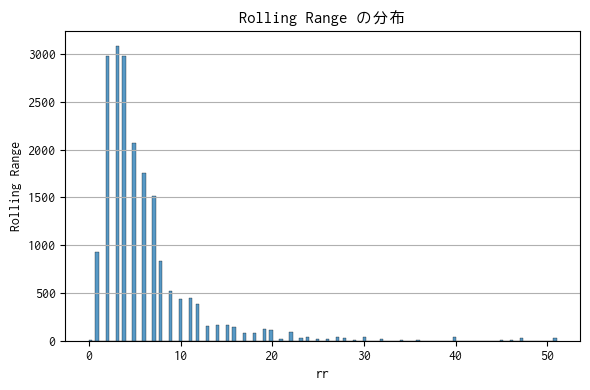

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [25]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  利確1   建玉
2026-01-15 09:00:03    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-15 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-15 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-15 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0  0.0
2026-01-15 09:00:07    0.0    0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...
2026-01-15 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  1.0
2026-01-15 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  1.0
2026-01-15 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  1.0
2026-01-15 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  1.0
2026-01-15 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  1.0

[19429 rows x 7 columns]


output/2026/01/15/7011_trend_obs.png


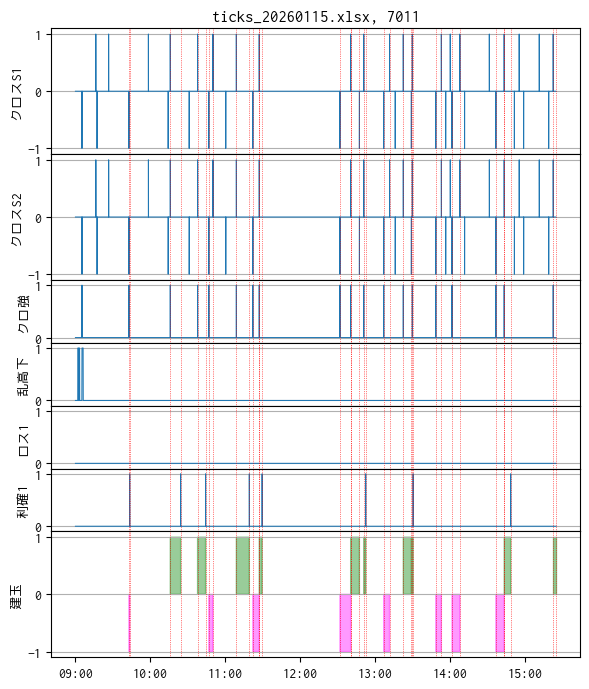

In [26]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()